<img src="img/dsci572_header.png" width="600">

# Lecture 1: Floating-Point Numbers

<br><br><br>

## Lecture Learning Objectives


- Compare and contrast the representations of integers and floating-point numbers

- Explain how double-precision floating-point numbers are represented by 64 bits
- Identify common computational issues caused by floating-point numbers, e.g., rounding, overflow, etc.
- Calculate the "spacing" of a 64 bit floating-point number in Python
- Write code defensively against numerical errors
- Use `numpy.iinfo()`/`numpy.finfo()` to work out the possible numerical range of an integer or float dtype

<br><br><br>

## Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.floating_point import *

%config InlineBackend.figure_formats = ['svg']
plt.rcParams.update({'font.size': 12, 'axes.labelweight': 'bold', 'figure.figsize': (6, 4)})

<br><br><br>

## Floating Point Errors


- Unfortunately, computers can not always represent numbers as accurately as some of us might think

- The problem boils down to this: we have a finite amount of bits in our computer to store an infinite amount of numbers
- This inevitably leads to precision errors as we'll explore in this lecture
- Some motivating examples:

In [2]:
0.1 + 0.2 == 0.3

False

In [3]:
1e16 + 1 == 1e16

True

In [4]:
1e16 + 0.7 + 0.7  == 1e16

True

- In this lecture, we are going to take a journey to discover why this happens!

<br><br><br>

## Binary Numbers and Integers


- We are used to using a base-10 number system (i.e., "decimal" or "denary")

- For example, we can read the number 104 as:
    - 1 x 100 ($10^2$)
    - 0 x 10 ($10^1$)
    - 4 x 1 ($10^0$)

- Or in a tabular format:

| Unit | $10^2$ | $10^1$ | $10^0$ |
|:---|:----|:----|:----|
|Value | 100   | 10   |1 |
|Number of units|1   |0   |   4|
|**Total**|**100**   |**0**   |   **4**|

- Many of you will be aware that computers use a base-2 system (i.e., "binary") to store data

- Binary is based on powers of 2 rather than powers of 10 and we only have two numbers (0 and 1) to work with (think of them as "off" and "on" switches respectively)
- If you're interested in learning more about how computers work under the hood, check out [this excellent Youtube series on computer science by CrashCourse](https://www.youtube.com/playlist?list=PL8dPuuaLjXtNlUrzyH5r6jN9ulIgZBpdo&app=desktop)
- In binary, 104 looks like:

In [5]:
f"{104:b}"  # I'm using the python f-string format code "b" to display my integer in binary

'1101000'

We can also directly obtain the binary representation of a number using Python's built-in `bin()` function:

In [6]:
bin(104)

'0b1101000'

- So this is:
    
|Unit|$2^6$ |$2^5$ |$2^4$ |$2^3$ |$2^2$ |$2^1$ |$2^0$ |
|:---|:----|:----|:----|:---|:---|:---|:---|
|Value|64   |32   |   16|   8|   4|   2| 1|
|Number of units|1   |1   |   0|   1|   0|   0| 0|
|**Total**|**64**   |**32**   | **0** | **8**| **0**| **0**| **0**|

- We call these single binary 0/1 values, **bits**

- So we needed 7 bits to represent the number 104
- We can confirm using the `.bit_length()` integer method

In [7]:
x = 104
x.bit_length()

7

- Here are the first 10 positive integers in binary (using 4 bits):

In [8]:
print("DECIMAL | BINARY")
print("================")
for _ in range(11):
    print(f"   {_:02}   |  {_:04b}")

DECIMAL | BINARY
   00   |  0000
   01   |  0001
   02   |  0010
   03   |  0011
   04   |  0100
   05   |  0101
   06   |  0110
   07   |  0111
   08   |  1000
   09   |  1001
   10   |  1010


- And a useful GIF counting up in binary to drive the point home:

<img src="img/binary-denary.gif" width="400">

Source: [futurelearn.com](https://www.futurelearn.com/courses/how-computers-work/0/steps/49261)

<br><br><br>

- The range of **unsigned integers** we can represent with `N` bits is: 0 to $2^{N}-1$, just like the range of unsigned integers with `N` digits is: 0 to $10^{N}-1$.

- The range of **signed integers** you can represent with `N` bits is: $-2^{N-1}$ to $2^{N-1}-1$

> **(OPTIONAL)** You don't really need to know this, but it's worth mentioning that:
>
>The reason for why the range of 8-bit integers is -128 to 127, instead of -127 to 127 is because of a particular way of representing negative numbers in computer hardware (see these Wikipedia links: [1](https://en.wikipedia.org/wiki/Signed_number_representations) and [2](https://en.wikipedia.org/wiki/Method_of_complements)), known as **two's complement** (this is the most widely used system today, but there are also other systems which you can find the Wikipedia article).
>
>- It is basically a workaround, on the hardware level, to avoid having different methods for addition and subtraction for positive and negative numbers. In decimal, it's like saying 700 - 250 = 450 can be done by writing 700 + 750 = 1450 and then drop the 1, giving 450 (750 is the tens's complement of 250). Put otherwise, **we turned a subtraction operation into an addition by doing this**.
>
>- There is no negative zero in this system, which is why we get one more number to store for free (1,000,0000 in binary represents -128 in decimal). The more important implication of this is that there's no check needed to see if non-zero values are not just negative zero (e.g., 1000 is non-zero, but would be interpreted as negative zero in a 4-bit digit that uses the sign-and-magnitude system of representing negative numbers).

- For example, with 8 bits we can represent the unsigned integers 0 to $2^8 - 1 = 255$, or signed integers from -128 to 127:

In [9]:
bits = 8
print(f"unsigned min: 0")
print(f"unsigned max: {2 ** bits - 1}\n")
print(f"signed min: {-2 ** (bits - 1)}")
print(f"signed max: {2 ** (bits - 1) - 1}")

unsigned min: 0
unsigned max: 255

signed min: -128
signed max: 127


- We can confirm all this with the numpy function `np.iinfo()`:

In [10]:
np.iinfo("int8")  # use np.iinfo() to check out the limits of a dtype

iinfo(min=-128, max=127, dtype=int8)

In [11]:
np.iinfo("uint8")  # "uint8" is an unsigned 8-bit integer, so ranging from 0 to 2^7

iinfo(min=0, max=255, dtype=uint8)

- Depending on the language/library you're using, you may get an error or some other funky behaviour if you try to store an integer smaller/larger than the allowable

In [12]:
np.array([-129, 256]).astype("int8")  # these numbers are outside the allowable range!

array([127,   0], dtype=int8)

<br><br><br>

**(OPTIONAL) Reason:**

In case of 256, it merely converts it to binary:

In [13]:
bin(256)

'0b100000000'

and then forces it to an 8-bit memory location, which means that only the zeros in 100000000 will be retained, and the 9-th digit (the leftmost 1) will be discarded. Therefore, we get zero.

On the other hand, since -129 is a negative number, NumPy computes the two's complement of 129. To do that:

- the first step is to flip 0s to 1s and 1s to 0s in `10000001` (the binary representation of unsigned 129), which gives `01111110`

- and then add 1 to the result: `01111110 + 1 = 01111111`. This bit pattern already belongs to another number in that range:

In [14]:
int(0b01111111)

127

This image below, which shows the 2's complement circle in case of a 4-bit digit ([source](https://davidalbertoadler.com/assets/img/twos-complement.png)), makes this process more clear:

<img src="https://davidalbertoadler.com/assets/img/twos-complement.png" width="300">

<br><br><br>

- To store the example values above, we need more bits in the memory
- For example, 16 bits will be more than enough:

In [15]:
np.array([-129, 128]).astype("int16")

array([-129,  128], dtype=int16)

- You often see bits in multiples of 8 (e.g., 8, 16, 32, 64, etc)
- 8 bits is traditionally called 1 "byte"

**Note:** Python does not restrict the number of bits for storing an integer. It can dynamically allocate more memory to store your integer if needed.

In [16]:
x = 2 ** 100
x

1267650600228229401496703205376

In [17]:
x.bit_length()

101

<br><br><br>

## Fractional Numbers in Binary


- At this point you might be thinking, "Well that's all well and good for integers, but what about fractional numbers like 14.75?"

- Let's interpret the number 14.75 in our familiar decimal format

|Unit| $10^1$ |$10^0$ | $10^{-1}$ | $10^{-2}$ |
|:---|:----|:----|:----|:---|
|Value|10   |1   |   0.1|   0.01|
|Number of units|1   |4   |   7|   5|
|**Total**|**10**   |**4**  |   **0.7**|  **0.05**|

- That seems pretty natural, and in binary it's much the same

- Anything to the right of the decimal point (now called a "binary point") is treated with a **negative exponent**
- So in binary, 14.75 would look like this: 1110.11

- Let's break that down:

|Unit|$2^3$ |$2^2$ |$2^1$ |$2^0$ |$2^{-1}$ |$2^{-2}$ |
|:---|:----|:----|:----|:---|:---|:---|
|Value|8   |4   |   2|   1|   0.5|   0.25|
|Number of units|1   |1   |   1|   0|   1|   1|
|**Total**|**8**   |**4**   | **2** | **0**| **0.5**| **0.25**|

<br><br><br>

## Fixed Point Numbers


- As we learned earlier, we typically have a fixed number of bits to work with when storing a number, e.g., 8, 16, 32, 64 bits etc.

- How do we decide where to put the binary point to allow for fractional numbers?
- With 8 bits, one option is to put **4 bits on the left and 4 on the right**:

|Unit|$2^{3}$ |$2^{2}$ |$2^{1}$ |$2^{0}$ |$2^{-1}$|$2^{-2}$|$2^{-3}$|$2^{-4}$|
|---|----|----|---|---|---|---|---|---|
|Value|8   |   4|   2|   1|   0.5|   0.25|   0.125|   0.0625|

- In this case, the largest and smallest (closest to 0) numbers we could represent in the unsigned case are:

In [18]:
(2.0**np.arange(-4, 4, 1)).sum()

15.9375

In [19]:
2 ** -4

0.0625

- But what if we wanted to represent numbers larger than this?

- We could shift the binary point right, so we have 6 on the left and 2 on the right, then our range would be:

In [20]:
(2.0 ** np.arange(-2, 6, 1)).sum()

63.75

In [21]:
2 ** -2

0.25

- We get this trade-off between being able to represent large numbers and small numbers

- What if we want to represent both very large and very small numbers?

<br><br><br>

## Floating-point numbers


- Rather than having a fixed location for our binary point, we could let it "float" around depending on what number we want to store

- Recall "scientific notation", which for the number 1234 looks like $1.234 \times 10^3$, or for computers we usually use `e` for shorthand:

In [22]:
f"{1234:.3e}"

'1.234e+03'

- The "exponent" controls the location of the decimal point

- Consider the following numbers:
    - $1.234 \times 10^0 = 1.234$
    
    - $1.234 \times 10^1 = 12.34$
    - $1.234 \times 10^2 = 123.4$
    - $1.234 \times 10^3 = 1234.$

<br><br><br>

- See how by changing the value of the exponent we can control the location of the floating point and represent a range of values?

- We'll be using the exact same logic with the binary system to come up with our "floating-point numbers"

- This means that **instead of powers of 10, we want to express numbers in powers of 2**

- This is floating point format:

$$1.\underbrace{M}_\text{Mantissa} \times \underbrace{2^E}_\text{Exponent}$$

- $M$ = Mantissa

- $E$ = Exponent

- In binary, $1.M$ is always between 1 and 2, just like in decimal the significand is always between 1 and 10 (if it's bigger than that you simply add 1 to the powers of 2 or 10)

<br><br><br>

- Consider the number 10

- $10 = 1.25 \times 2^3$
- So $M=.25$ and $E=3$
- But we want binary, not decimal, so $M=01$ and $E=11$
- Therefore, 10 in floating point binary is: $1.01 \times 2^{11}$

  - Note that the $.$ is a **"binary point"** (or more generally the _radix point_), digits on the left are 2's with positive exponents, digits on the right are 2's with negative exponents


- This is where the magic happens, just as the exponent of 10 in scientific notation defines the location of the decimal point, so does the exponent of a floating-point number define the location of the binary point

- For $1.01 \times 2^{11}$, the exponent is 11 in binary and 3 in decimal, so move the binary point three places to the right: $1.01 \times 2^{11} = 1010.$
- What is 1010 in binary?

In [23]:
int(0b1010)

10

- We now have this "floating-point" data type that uses an exponent to help us represent both small and large fractional numbers (unlike fixed point where we would have to choose one or the other)

- I wrote a function `binary()` to display any number in floating point format:

In [24]:
binary(10)

 Decimal: 1.25 x 2^3
  Binary: 1.01 x 2^11

    Sign: 0 (+)
Mantissa: 01 (0.25)
Exponent: 11 (3)


- Let's try the speed of light: $2.998 \times 10 ^ 8 m/s$

In [25]:
binary(2.998e8)

 Decimal: 1.11684203147888184 x 2^28
  Binary: 1.0001110111101001010111 x 2^11100

    Sign: 0 (+)
Mantissa: 0001110111101001010111 (0.11684203147888184)
Exponent: 11100 (28)


- A mole: $6.02214076 \times 10^{23}$ particles

In [26]:
binary(6.02214076e23)

 Decimal: 1.9925592330949422 x 2^78
  Binary: 1.1111111000011000010111001010010101111100010100010111 x 2^1001110

    Sign: 0 (+)
Mantissa: 1111111000011000010111001010010101111100010100010111 (0.9925592330949422)
Exponent: 1001110 (78)


- Planck's constant: $6.62607004 \times 10^{-34} \left[m^2 kg / s\right]$

In [27]:
binary(6.62607004e-34)

 Decimal: 1.720226132656187 x 2^-111
  Binary: 1.1011100001100000101111010110010101111011100111100001 x 2^-1101111

    Sign: 0 (+)
Mantissa: 1011100001100000101111010110010101111011100111100001 (0.720226132656187)
Exponent: -1101111 (-111)


- You get the point, we can represent a wide range of numbers with this format.

<br><br><br>

### Floating Point Standard

- One question you might have about the above: how many bits should I use for the mantissa and how many for the exponent?

- Well that's already been decided for you in: IEEE Standard for Floating-Point Arithmetic ([IEEE 754](https://en.wikipedia.org/wiki/IEEE_754)) which is what most computers/software use
- You'll mostly be using the data types `float64` and `float32`

- **Float 64** (also called "double precision")

  - 1 bit for the overall sign
  - 52 bits for the mantissa ([plus 1 implied bit](https://stackoverflow.com/a/18409644))
  - 11 bits for the exponent
  
<img src="img/float64.png" width="600">

[image source](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/IEEE_754_Double_Floating_Point_Format.svg/1236px-IEEE_754_Double_Floating_Point_Format.svg.png)

- **Float 32** (also called "single precision")

  - 1 bit for the overall sign
  - 23 bits for the mantissa (plus 1 implied bit)
  - 8 bits for the exponent

<img src="img/float32.png" width="600">

[image source](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Float_example.svg/1180px-Float_example.svg.png)

<br><br><br>

## Rounding Errors and Spacing


### Rounding Errors

- Many fractional numbers can't be represented exactly using binary

- **Instead, your computer will round numbers to the closest representable number and we get rounding errors**
- For example, 0.1 can't be exactly represented in binary (feel free to try and make 0.1 using binary floating point format).
- Python usually hides this fact for us out of convenience:

In [28]:
0.1

0.1

but here is what's stored in the memory as 0.1:

In [29]:
f"{0.1:.100f}"

'0.1000000000000000055511151231257827021181583404541015625000000000000000000000000000000000000000000000'

- So 0.1 is actually represented as a number slightly bigger than 0.1

- I wrote a function to work out if a number is stored exactly or inexactly, and to show the rounding error:

In [30]:
float_rep(0.1)

You entered: 0.1
Which is inexactly stored as: 0.1000000000000000055511151231257827021181583404541015625


In [31]:
float_rep(0.25)

You entered: 0.25
Which is exactly stored as: 0.25


- Read more about float representation in the Python docs [here](https://docs.python.org/3/tutorial/floatingpoint.html).

<br><br><br>

### Spacing

- So how bad are these rounding errors? Let's find out...

- We can quantify the "spacing" between representable numbers
- Imagine we're in the decimal system again:
  - **For a number with a fixed number of significant digits**, the spacing between that number and the next greater number can be determined as the smallest significant digit multiplied by the exponent:

|Number| Next greater| Spacing|
|---|---|---|
|8.982e0| 8.983e0 | 0.001e0 = 0.001|
|0.001e1| 0.002e1 | 0.001e1 = 0.01|
|3.423e2| 3.424e2 | 0.001e2 = 0.1|

- The spacing can be determined as **the smallest part of the mantissa multiplied by a number's exponent**

- The same goes for binary. The steps happen at every power of 2 instead of 10, and we have way more digits after the decimal (52 instead of 3), but everything else is pretty much the same.
- So the spacing size, as a function of the number itself, is a staircase function:

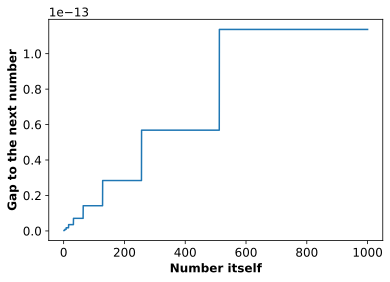

In [32]:
x = np.linspace(1, 1000, 100000)

spacing = (2 ** -52) * 2**np.floor(np.log2(x))
plt.plot(x, spacing)
plt.xlabel("Number itself")
plt.ylabel("Gap to the next number");

- For `float64`, we have 52 explicit bits for the mantissa, therefore the smallest significant digit is $2^{-52}$

In [33]:
2 ** -52

2.220446049250313e-16

- Numpy has a helpful function we can use to calculate spacing

- `np.nextafter(x1, x2)` returns the next representable floating-point value after `x1` towards `x2`
- The next representable number after 1 should be 1 plus the spacing above, let's check:

In [34]:
np.nextafter(1, 2)

1.0000000000000002

In [35]:
spacing = np.nextafter(1, 2) - 1
spacing

2.220446049250313e-16

In [36]:
spacing == (2 ** -52) * (2**0)

True

- If you do a calculation that puts you somewhere between the **space** of two numbers, the computer will automatically round to the nearest one

- I like to think of this as a mountain range in the computer
- In the valleys are representable numbers, if a calculation puts us on a mountain side, we'll roll down the mountain to the closest valley
- For example, spacing for the number 1 is $2^{-52}$, so if we don't add at least half that, we won't reach the next representable number:

In [37]:
1 + 0.4 * spacing == 1  # add less than half the spacing

True

<img src="img/fall_left.png" width="500">

In [38]:
1 + 0.6 * spacing == 1 # add a more than half the spacing

False

<img src="img/fall_right.png" width="500">

- We're working with pretty small numbers here so you might not be too shocked

- But remember, the bigger our exponent, the bigger our rounding errors will be!

In [39]:
large_number = 1e25

In [40]:
binary(large_number)

 Decimal: 1.03397576569128469 x 2^83
  Binary: 1.0000100010110010101000101100001010000000001010010001 x 2^1010011

    Sign: 0 (+)
Mantissa: 0000100010110010101000101100001010000000001010010001 (0.03397576569128469)
Exponent: 1010011 (83)


- The exponent is 83 so the spacing should be:

In [41]:
spacing = (2 ** -52) * (2 ** 83)
print(f"{spacing:.5e}")

2.14748e+09


- 1 billion is less than half that spacing, so if we add it to `large_number`, we won't cross the mountain peak, and we'll slide back down into the same valley:

In [42]:
one_billion = 1e9
1e25 + one_billion == 1e25  # adding a billion didn't change our number!

True

- 2 billion is more than half that spacing, so if we add it to `large_number`, we'll slide into the next valley (representable number):

In [43]:
two_billion = 2e9
1e25 + two_billion == 1e25  # adding two billion (more than half the spacing) did change our number

False

- Another implication of having a finite number of floating point digits to represent an infinite number system is that two numbers may share the same representation in memory

- For example, these are all `True`:

In [44]:
0.99999999999999999 == 1

True

In [45]:
1.00000000000000004 == 1

True

In [46]:
1.00000000000000009 == 1

True

- No matter what number you are, if you don't pass over the peak to your left or right, you'll roll back down to the valley

- And also remember, the bigger the number, the bigger the spacing/rounding errors

<br><br><br>

## Lecture Exercise: Fun with Floating Points


### Floating Point Range

Recall that most compute environments you'll encounter will be using IEEE double precision (`float64`), so 52 bits for the mantissa, 11 for the exponent. In order to obtain the range of values for IEEE `float64`, we first need to know that the **exponent** in this standard is expressed differently than we expect. Let's see:

<br><br><br>

With 11 bits, we would expect the range of representable signed integers to be $-2^{10} - 1$ to $2^{10} - 1$ (i.e. $-1023$ to $+1023$). We learned in previous sections that the two's-complement system avoids having both $-0$ and $+0$, and thus enables us to store one more number instead of one of those signed zeros.

Instead of the two's-complement system, however, IEEE `float64` numbers use a **biased format** to represent the exponent.

This is done to make comparison between two floating-point numbers easier, if the entire bit pattern is taken to be an integer (see [this](https://indepth.dev/posts/1018/the-mechanics-behind-exponent-bias-in-floating-point#advantages-over-two-s-complement) for more info).

- In the biased format, **the entire signed exponent is represented as an unsigned integer, with a bias subtracted from it**. With 11 bits, the range of **unsigned** values we can store would be $0$ to $2^{11} - 1$ or $2047$.

- With the bias set to $1023$, the range of **signed** values represented by those numbers would be

$0 - 1023 = -1023$

to

$2047 - 1023 = 1024$


- Two numbers from that range are used for [special cases](https://people.orie.cornell.edu/snp32/orie_6125/ieee754/ieee754.html) (such as subnormal numbers or infinities):

  - all 0 bits ($-1023$), and
  
  - all 1 bits ($+1024$)

- Finally, this means that the smallest exponent is $-1022$ and the greatest exponent is $+1023$.

<br><br><br>

- For `float64`, the maximum mantissa can be calculated as the sum of all 52 bits from ($2^{-1}$ to $2^{-52}$):

In [47]:
max_mantissa = (2.0 ** np.arange(-1, -53, -1)).sum()
max_mantissa

0.9999999999999998

- Therefore the maximum float we can represent is (remember our format is $1.M \times 2 ^ E$):

In [48]:
(1 + max_mantissa) * 2 ** 1023

1.7976931348623157e+308

- Let's confirm using the `numpy` function `np.finfo()`:

In [49]:
np.finfo(np.float64).max

1.7976931348623157e+308

- What happens if we try to make a number bigger than this?

In [50]:
10. ** 309

OverflowError: (34, 'Result too large')

- Or in `numpy`, it throws a warning and defaults to `inf`:

In [51]:
np.power(10.0, 309)

/var/folders/qm/c_scj_0n7vj7r36900wc3j140000gn/T/ipykernel_34598/1970181666.py:1: RuntimeWarning: overflow encountered in power
  np.power(10.0, 309)


inf

- Now let's do the minimum value:

In [52]:
1.0 * (2 ** -1022)

2.2250738585072014e-308

- You don't need to worry about this derivation too much, after all `numpy` can help!

In [53]:
np.finfo(np.float64).minexp  # minimum exponent value

-1022

In [54]:
np.finfo(np.float64).tiny  # smallest possible positive value

2.2250738585072014e-308

<br><br><br>

### (OPTIONAL) Subnormal Numbers

- What happens if we try to store a number smaller than the above?

In [55]:
2 ** -1024

5.562684646268003e-309

- Um, it worked... 🤔

- Remember how I discussed "special bit patterns" earlier? One of these is "[subnormal numbers](https://en.wikipedia.org/wiki/Denormal_number)"
- This is well beyond the scope of the course, but briefly, subnormal numbers help us fill the gap between 0 and $2^{-1022}$
- If the exponent is set to its minimum value, then we can play with the bits (if we are willing to sacrifice precision): **instead of the mantissa starting with a 1, we can start it with a 0**
- This gives our mantissa a minimum value of $2^{-52}$ (rather than 1, which is what we had before)
- So the smallest subnormal number we can have is $2^{-52} \times 2 ^ {-1022} = 2 ^ {-1074}$:

In [56]:
2 ** -1074

5e-324

- Anything less than this is rounded to 0:

In [57]:
2 ** -1075

0.0

> Note that with subnormal numbers, we lose more and more precision for smaller and smaller numbers, because we can no longer use the exponent to make the binary point float around.

- You can read more [in this article](https://people.orie.cornell.edu/snp32/orie_6125/ieee754/ieee754.html#subnormal-numbers) and this [stackoverflow post](https://stackoverflow.com/a/14002396/14179508), but as I said, this is beyond the scope of the course.

<br><br><br>

### Order of Operations

- Consider the following:

In [58]:
1e16 + 1 + 1 == 1 + 1 + 1e16

False

- What's up with that?

- Let's break it down...
- First the spacing of `1e16` is:

In [59]:
calc_spacing(1e16)

2.0

In [60]:
1e16 + 1 == 1e16

True

- So the above should make sense, we aren't adding more than half the spacing, so we remain at `1e16`

- Another example:

In [61]:
1e16 + (1 + 1) == 1e16

False

- This time we added `(1 + 1)`, which is more than half the spacing, and we got a `False` as expected

- But now let's remove the parentheses:

In [62]:
1e16 + 1 + 1 == 1e16

True

- Back to `True`, what's going on...

- Well we have an "order of operations" here, the `1e16 + 1` happens first, which is just `1e16`, and then we try add `1` again but the same thing happens
- What do you think will happen with this one?

In [63]:
1 + 1 + 1e16 == 1e16

False

- This time, the `1 + 1` happened first, which is `2`, and then we add `1e16`

<br><br><br>

### Writing Functions

- Later in this course we'll create a Logistic Regression model from scratch and you'll have to calculate something that looks like:

$\log(1+\exp(z))$

- Looks pretty harmless right?

In [64]:
def log_1_plus_exp(z):
    return np.log(1 + np.exp(z))

- But what happens if `z` is large? Say, 1000:

In [65]:
log_1_plus_exp(1000)

/var/folders/qm/c_scj_0n7vj7r36900wc3j140000gn/T/ipykernel_34598/2578511584.py:2: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(z))


inf

- We get an overflow error when `z` in `exp(z)` is large!

- In fact, we can find out what the limit of `z` is:

In [66]:
max_float = np.finfo(np.float64).max
max_float

1.7976931348623157e+308

In [67]:
np.log(max_float)

709.782712893384

- If we pass anything bigger than that into `np.exp()` we'll get an overflow error

- However, you might know that for $z \gg 1$:

$\log(1+\exp(z)) \approx \log(\exp(z)) = z$

- e.g.:

In [68]:
z = 700
np.log(1 + np.exp(z))

700.0

The returned looks the same as $z$!

- We can use this to account for the overflow error:

In [69]:
@np.vectorize  # decorator to vectorize the function
def log_1_plus_exp_safe(z):
    if z > 100:
        print(f"Avoiding overflow error with approximation of {z:.0f}!")        
        return z
    else:
        return np.log(1 + np.exp(z))

In [70]:
log_1_plus_exp_safe([1, 10, 100, 1000])

Avoiding overflow error with approximation of 1000!


array([   1.31326169,   10.0000454 ,  100.        , 1000.        ])

- This is part of the reason we use libraries like `numpy`, `scipy`, `scikit-learn`, etc. They've taken care of all of this for us.

<br><br><br>

### Precision, Memory, Speed

- So double precision floats are pretty standard and require 64 bits to store:

In [71]:
np.float64().nbytes  # number of bytes consumed by a float64

8

In [72]:
np.float64().nbytes * 8  # recall 1 byte = 8 bits

64

- When dealing with huge datasets or models with millions or billions of parameters it may be desirable to lower the precision of our numbers to use less memory and/or gain speed

In [73]:
x64 = np.random.randn(1000, 1000)
print(f"array size: {x64.shape}")
print(f"array type: {x64.dtype}")
print(f"mem. usage: {x64.nbytes * 8 / (1000 * 1000)} MB")

array size: (1000, 1000)
array type: float64
mem. usage: 64.0 MB


In [74]:
x32 = x64.astype('float32')
print(f"array type: {x32.dtype}")
print(f"mem. usage: {x32.nbytes * 8 / (1000 * 1000)} MB")

array type: float32
mem. usage: 32.0 MB


- Below I'm squaring the elements of my two arrays. They have the same number of elements, but different data types - let's observe the difference in the speed of the operation:

In [75]:
time64 = %timeit -q -o -r 3 x64 ** 2
time32 = %timeit -q -o -r 3 x32 ** 2
print(f"float32 array is {time64.average / time32.average:.2f}x faster than float64 array here.")

float32 array is 3.46x faster than float64 array here.


- I'm showing you this as foreboding for later topics dealing with memory and deep neural networks, where we'll use these ideas of precision vs speed to optimize our models.

<br><br><br>

## Lecture Highlights


1. Most fractional numbers are not represented exactly by floating-point numbers in computers which can lead to rounding errors.

2. Most compute environments you'll encounter will use IEEE double precision, but others do exist (especially single precision). Some software will require you to use a particular data type due to computational limitations (for example, PyTorch sometimes forces you to use `float32` instead of `float64`).

3. There is a biggest and smallest floating-point number (depending on precision), beyond these we get overflow or underflow errors. Use `np.nextafter()` and `numpy.finfo()` to work out float spacing and ranges.